**Downloading Dataset**

In [ ]:
# !pip install kaggle
# !mkdir /root/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# ! pip install --upgrade tensorflow

In [2]:
from google.colab import drive

In [3]:
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [4]:
!cd "./drive/MyDrive/FDD Project/dataset"

In [5]:

# !kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

In [6]:
# !unzip "/content/drive/MyDrive/FDD Project/dataset/corn-or-maize-leaf-disease-dataset.zip"

**Importing LIbraries**

In [7]:
!pip install split-folders
! pip install python_splitter

In [8]:
import tensorflow as tf
import numpy as np
import splitfolders
import python_splitter
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras import losses
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Preprocessing Data**

In [ ]:
# splitfolders.ratio("/content/drive/MyDrive/FDD Project/dataset/data",
#                    output="/content/drive/MyDrive/FDD Project/dataset/corn",
#                    seed=42,
#                    ratio=(.8, .2, .0)
#                    )

In [10]:
train_dir = "/content/drive/MyDrive/FDD Project/dataset/corn/train"
test_dir = "/content/drive/MyDrive/FDD Project/dataset/corn/val"


In [11]:
gen = ImageDataGenerator(rescale=1./255,
                         rotation_range=40,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         brightness_range=[0.8, 1.2],
                         fill_mode='nearest',
                         validation_split= 0.2
)

In [12]:
test_gen = ImageDataGenerator(rescale= 1./255)

In [13]:
train_generator= gen.flow_from_directory(
    train_dir,
    target_size=(299,299),
    class_mode = "categorical",
    subset="training",
    batch_size =1,
    seed=2020
)


Found 3348 images belonging to 4 classes.


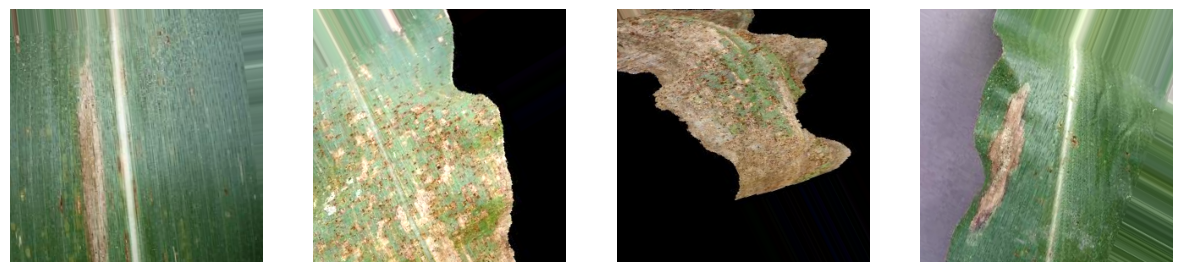

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    image = next(train_generator)[0]

    # Rescale pixel values from [0, 1] to [0, 255]
    image = np.squeeze(image) * 255.0

    # Convert the pixel values to uint8 type
    image = image.astype('uint8')

    # Display the image
    ax[i].imshow(image)
    ax[i].axis('off')


In [ ]:
val_generator = test_gen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    class_mode= "categorical",
    subset="validation"
)

In [ ]:
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size = (299,299)
)

**Model Building**

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
base2 = InceptionV3(weights="imagenet",include_top=False ,input_shape=(299,299,3))
# Set the bottom 10 layers to be trainable
for layer in base_model.layers[-10:]:
    layer.trainable = True


In [ ]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation="relu"))
num_classes = 4
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
def custom_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(custom_schedule)


In [ ]:
from keras.api._v2.keras import activations
model_2  = Sequential()
model_2.add(base2)
model_2.add(GlobalAveragePooling2D())
model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dense(256, activation="relu"))
model_2.add(Dense(128, activation="relu"))
model_2.add(Dense(32, activation="relu"))
model_2.add(Dense(4, activation="softmax"))

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"]
                )

In [ ]:
model_2.summary()


In [ ]:
history = model.fit(train_generator,
                    batch_size=54,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps=int(0.25 * 54),
                    callbacks = [lr_scheduler]
                    )

In [ ]:
hist_2 = model_2.fit(train_generator,
                     batch_size=int(len(train_generator)),
                     epochs = 50,
                     validation_data = val_generator,
                     validation_steps= int(len(val_generator)),
                     callbacks = [lr_scheduler]
                     )

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Assuming `test_generator` is your test data generator
test_loss, test_acc = model_2.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
model.save("model_2.h5", save_format="h5")

In [ ]:
img_path= "/content/gls.jpg"
img = image.load_img(img_path, target_size= (224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
class_names = ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']
prediction = model.predict(x)

predicted_class = class_names[np.argmax(prediction)]

In [ ]:
predicted_class